In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score, confusion_matrix
from lightgbm import LGBMClassifier

from shapmat.abundance_filter import ab_filter
from itertools import combinations

from statannotations.Annotator import Annotator
import ast

In [63]:
### SUBSPECIES-LEVEL DATA ###

sample_metadata = pd.read_csv('../data/CRC_metadata.tsv',sep='\t',index_col=0)
sample_metadata = sample_metadata.query("study_condition != 'adenoma'")
sample_metadata = sample_metadata.loc[sample_metadata['study_condition'].isin(['control','CRC'])]


relab_subsp = pd.read_csv("../data/relab_subsp.tsv",sep='\t',index_col=0)
relab_subsp.index = relab_subsp.index.astype(str).str.rjust(10,'0')
relab_subsp = relab_subsp.T
relab_subsp = relab_subsp.loc[relab_subsp.index.isin(sample_metadata.index)]
sample_metadata = sample_metadata.loc[relab_subsp.index]

In [64]:
### SPECIES-LEVEL DATA ###

relab_sp = pd.read_csv("../data/relab_sp.tsv",sep='\t',index_col=0)
relab_sp = relab_sp / relab_sp.sum()
relab_sp = relab_sp.T


In [65]:
relab_sp = relab_sp.loc[relab_sp.index.isin(relab_subsp.index)]
relab_subsp = relab_subsp.loc[relab_subsp.index.isin(relab_sp.index)]

In [66]:
sample_metadata = sample_metadata.loc[relab_subsp.index]

In [67]:
def make_combinations(input_list):
    list_of_combinations = []
    for r in range(1, len(input_list) + 1):
        list_of_combinations.extend(list(combinations(input_list, r)))
    list_of_combinations_as_lists = [list(comb) for comb in list_of_combinations]
    return list_of_combinations_as_lists


def train_models(relab, sample_metadata, data_type, train_study, test_study):
    
    output_df = pd.DataFrame()
    random_states =  [424, 646, 968]
    ### LBGM ###
    # specify your parameters 
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': 11,
        'learning_rate': 0.01,
        'verbose': -1
    }
    for random_state in random_states:
        y_train = sample_metadata.loc[sample_metadata['study'].isin(train_study)].study_condition
        X_train = relab.loc[y_train.index]


        y_test = sample_metadata.query("study == @test_study").study_condition
        X_test = relab.loc[y_test.index]      
 

        y_train = y_train.map({"control":0,"CRC":1})
        y_test = y_test.map({"control":0,"CRC":1})

        X_train_filtered = ab_filter(X_train,abundance_threshold=0.00001,prevalence_threshold=0.85)
        X_test_filtered = X_test[X_train_filtered.columns]
        # create dataset for lightgbm
        lgbm = LGBMClassifier(**params, n_estimators=500, random_state = random_state)

        # train the model
        lgbm.fit(X_train_filtered, y_train)
        # predict the probabilities of the positive class
        y_pred_proba = lgbm.predict_proba(X_test_filtered)[:, 1]
        y_pred = lgbm.predict(X_test_filtered)

        # compute ROC AUC from prediction scores
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        confusion_matrix_score = confusion_matrix(y_test, y_pred)
        ppv = confusion_matrix_score[1,1] / confusion_matrix_score[1,:].sum()
        npv = confusion_matrix_score[0,0] / confusion_matrix_score[0,:].sum()
        
        output_df = pd.concat([output_df, pd.DataFrame({"model":"LBGM", "train_study":[train_study],"test_study":test_study, 'data_type':data_type,"roc_auc":roc_auc,
                                                       "accuracy":accuracy, "recall":recall, "f1_score":f1, 'ppv':ppv, 'npv':npv, 'random_state':random_state},
                                                       index=[data_type])], axis=0)
    return output_df
    

In [68]:
performance_subspecies = pd.DataFrame()
all_studies = sample_metadata.study.unique()
for test_study in sample_metadata.study.unique():
    without_test = [x for x in all_studies if x != test_study]
    all_combinations = make_combinations(without_test)
    
    for train_group in all_combinations:
        study_performance = train_models(relab_subsp, sample_metadata, 'subspecies', train_group, test_study)
        performance_subspecies = pd.concat([performance_subspecies, study_performance],axis=0)


In [69]:
performance_species = pd.DataFrame()
all_studies = sample_metadata.study.unique()
for test_study in sample_metadata.study.unique():
    without_test = [x for x in all_studies if x != test_study]
    all_combinations = make_combinations(without_test)
    
    for train_group in all_combinations:
        study_performance = train_models(relab_sp, sample_metadata, 'species', train_group, test_study)
        performance_species = pd.concat([performance_species, study_performance],axis=0)


In [36]:
# performance_subspecies.to_csv("performance_training_size_subspecies.tsv",sep='\t',index=False)
# performance_species.to_csv("performance_training_size_species.tsv",sep='\t',index=False)

In [70]:
#performance_subspecies = pd.read_csv("performance_training_size_subspecies.tsv",sep='\t')
#performance_subspecies['train_study'] = performance_subspecies['train_study'].apply(ast.literal_eval)
performance_subspecies['n_train_studies'] = performance_subspecies['train_study'].apply(len)

subspecies_median = pd.DataFrame(performance_subspecies.groupby(["test_study","n_train_studies"])['roc_auc'].median()).reset_index()

subspecies_median = subspecies_median.groupby(['n_train_studies'])['roc_auc'].agg(['median', 'sem']).reset_index()

In [71]:
#performance_species = pd.read_csv("performance_training_size_species.tsv",sep='\t')
#performance_species['train_study'] = performance_species['train_study'].apply(ast.literal_eval)
performance_species['n_train_studies'] = performance_species['train_study'].apply(len)

species_median = pd.DataFrame(performance_species.groupby(["test_study","n_train_studies"])['roc_auc'].median()).reset_index()

species_median = species_median.groupby(['n_train_studies'])['roc_auc'].agg(['median', 'sem']).reset_index()

In [72]:
subspecies_median['level'] = 'subspecies'
species_median['level'] = 'species'

In [73]:
total_df = pd.concat([species_median,subspecies_median])

In [74]:
total_df = total_df.sort_values('level')

In [75]:
total_df = total_df.reset_index(drop=True)

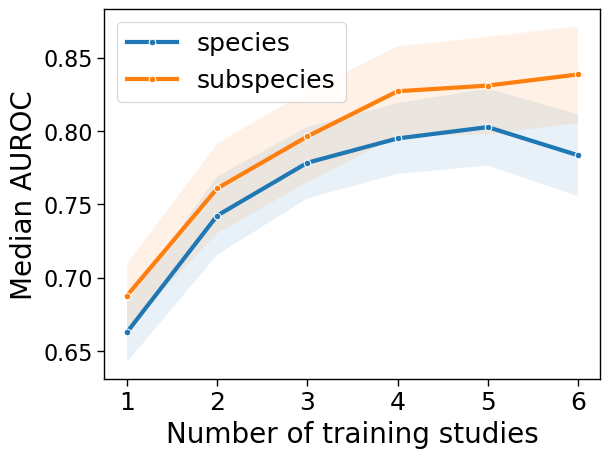

In [76]:
sns.set_context('paper')
sns.lineplot(data=total_df, x='n_train_studies', y='median', marker='o',linewidth=3,hue='level')
plt.xlabel("Number of training studies",fontsize=20)
plt.ylabel("Median AUROC",fontsize=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
# Iterating over each group to add shaded standard deviation
levels = total_df['level'].unique()

for level in levels:
    group_data = total_df[total_df['level'] == level]
    plt.fill_between(group_data['n_train_studies'], 
                     group_data['median'] - group_data['sem'], 
                     group_data['median'] + group_data['sem'], 
                     alpha=0.1)  # Adjust alpha for transparency
plt.legend(title='', fontsize=18)
#plt.savefig("median_AUROC_vs_n_training.svg", bbox_inches='tight')

In [77]:
subspecies_median_per_study = pd.DataFrame(performance_subspecies.groupby(["test_study","n_train_studies"])['roc_auc'].median()).reset_index()
species_median_per_study = pd.DataFrame(performance_species.groupby(["test_study","n_train_studies"])['roc_auc'].median()).reset_index()

In [78]:
subspecies_median_per_study['level'] = 'subspecies'
species_median_per_study['level'] = 'species'

In [79]:
per_study = pd.concat([subspecies_median_per_study,species_median_per_study])

In [80]:
per_study = per_study.reset_index(drop=True)

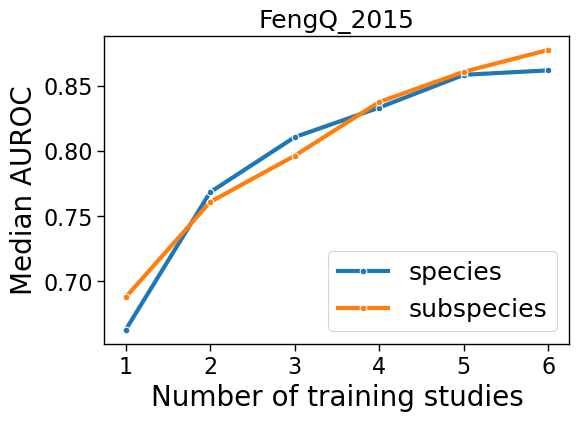

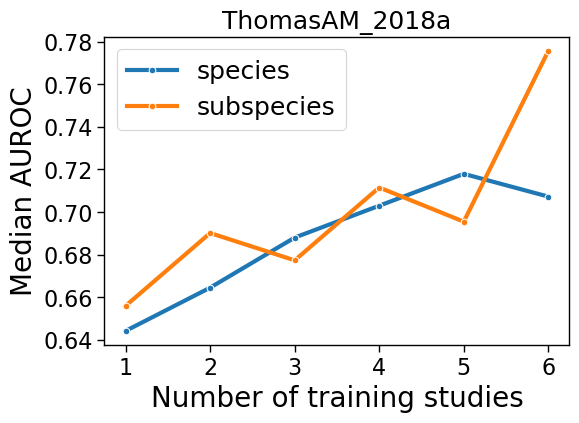

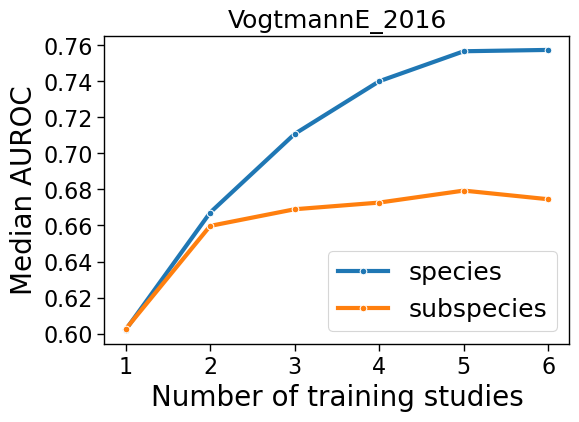

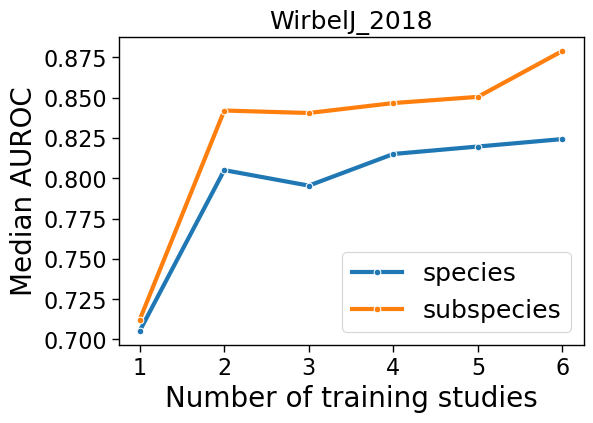

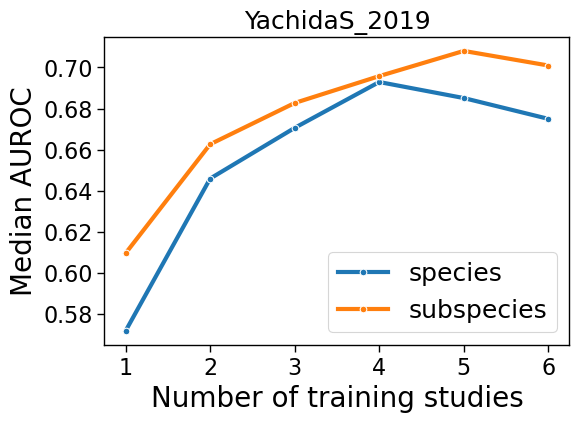

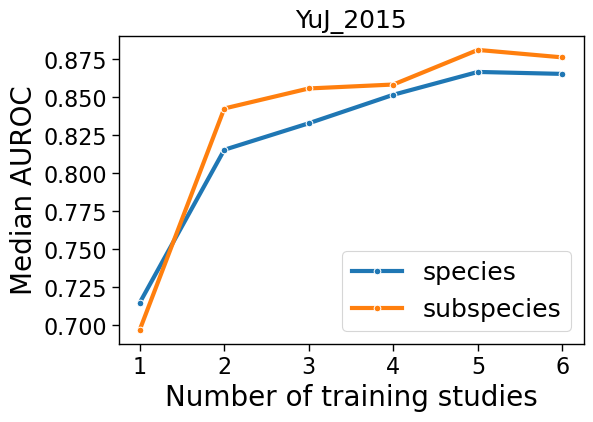

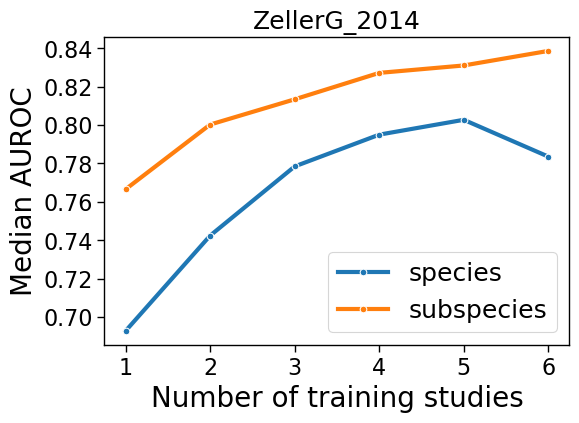

In [81]:
sns.set_context('paper')
for test_study in per_study.test_study.unique():
#test_study = 'FengQ_2015'
    plt.figure(figsize=(6,4))
    sns.lineplot(data=per_study.query("test_study == @test_study"), x='n_train_studies', y='roc_auc', marker='o',linewidth=3,hue='level', hue_order = ['species','subspecies'])
    plt.xlabel("Number of training studies",fontsize=20)
    plt.ylabel("Median AUROC",fontsize=20)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.legend(title='', fontsize=18)
    plt.title(test_study, fontsize= 18)
    #plt.savefig(f"training_size_variation/{test_study}.svg", bbox_inches='tight')
    plt.show()